In [1]:
# import all the libraries
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime 
import seaborn as sns 
import scipy.stats as stats

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)  

In [2]:
#read in all the files
drivers_ds = pd.read_csv("./driver_ids.csv")
rides_ds = pd.read_csv("./ride_ids.csv")
rides_ts = pd.read_csv("./ride_timestamps.csv")


In [3]:
#Convert the driver_onboard_date string to datetime
drivers_ds['driver_onboard_date'] = drivers_ds['driver_onboard_date'].apply(lambda d: datetime.datetime.strptime(d,'%Y-%m-%d %H:%M:%S'))

In [4]:
drivers_ds.describe()

,driver_id,driver_onboard_date
count,937,937
unique,937,49
top,a85adc80be31a10c23b7aaf380e39173,2016-04-05 00:00:00
freq,1,36
first,NaN,2016-03-28 00:00:00
last,NaN,2016-05-15 00:00:00


In [5]:
drivers_ds.driver_onboard_date.describe()

count                     937
unique                     49
top       2016-04-05 00:00:00
freq                       36
first     2016-03-28 00:00:00
last      2016-05-15 00:00:00
Name: driver_onboard_date, dtype: object

In [6]:
drivers_ds.head(2)

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29
1,007f0389f9c7b03ef97098422f902e62,2016-03-29


In [7]:
rides_ds.head(2)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0


In [8]:
rides_ts.head(2)

,ride_id,ride_picked_up_at
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:44:33
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:26:18


In [9]:
#Ride distance outliers -negative ride distance

#All these ride distances seem anamoly - hence for now leaving it there untill I use this in data model - as it could have been just the data read error

print(rides_ds.groupby(100*np.floor(rides_ds['ride_distance']/100)).ride_id.count().head(10))

print(rides_ds.groupby(100*np.floor(rides_ds['ride_distance']/100)).ride_id.count().tail(5))

ride_distance
-100.0      1
 0.0      875
 100.0    115
 200.0     96
 300.0    120
 400.0    178
 500.0    252
 600.0    404
 700.0    605
 800.0    845
Name: ride_id, dtype: int64
ride_distance
150500.0    1
156300.0    1
172400.0    1
276200.0    1
724600.0    1
Name: ride_id, dtype: int64


In [10]:
#Convert datetime string to datetime

rides_ts['ride_picked_up_at'] = rides_ts['ride_picked_up_at'].apply(lambda d: datetime.datetime.strptime(d,'%Y-%m-%d %H:%M:%S'))

In [11]:
#merging all the data and assuming 5% (10k/194k) of rides  have inconsistenet data and does not contain driver_ids - explore later incase these are cancellations

all_rides = pd.merge(rides_ds,rides_ts,on='ride_id',how='inner').merge(drivers_ds,on='driver_id', how='inner')

In [12]:
#Negative value for ride distance can be take out for data problem
all_rides.describe()

,ride_distance,ride_duration,ride_prime_time
count,184209.000000,184209.000000,184209.000000
mean,6945.197042,859.872292,17.373880
std,8938.015943,572.846146,30.833558
min,-2.000000,2.000000,0.000000
25%,2457.000000,492.000000,0.000000
50%,4007.000000,727.000000,0.000000
75%,7169.000000,1070.000000,25.000000
max,724679.000000,28204.000000,500.000000


In [13]:
#Activation rate
print("%.f%% drivers onboarded have taken rides in 3 months time  rest of drivers did not start driving " % (100*all_rides.driver_id.nunique()/float(drivers_ds.driver_id.nunique())))

89% drivers onboarded have taken rides in 3 months time  rest of drivers did not start driving 


In [14]:
# no missing data problem so far - YAY thanks for fairly clean data!!!
all_rides.isnull().sum()

driver_id              0
ride_id                0
ride_distance          0
ride_duration          0
ride_prime_time        0
ride_picked_up_at      0
driver_onboard_date    0
dtype: int64

In [15]:
all_rides.dtypes

driver_id                      object
ride_id                        object
ride_distance                   int64
ride_duration                   int64
ride_prime_time                 int64
ride_picked_up_at      datetime64[ns]
driver_onboard_date    datetime64[ns]
dtype: object

In [16]:
#Feature engineering

all_rides_main = all_rides.copy()

In [17]:
#all_rides_main = all_rides_main.copy()

In [18]:

all_rides[['ride_picked_up_at','driver_onboard_date']].describe()

,ride_picked_up_at,driver_onboard_date
count,184209,184209
unique,180996,49
top,2016-06-03 21:24:04,2016-04-05 00:00:00
freq,4,10696
first,2016-03-28 06:02:39,2016-03-28 00:00:00
last,2016-06-27 00:02:06,2016-05-15 00:00:00


In [19]:
#Feature engineering

#Add First and Last ride pickup date to the All_rides_data

def agg_columns(row):  
    row['ride_picked_up_at_first'] = row['ride_picked_up_at'].min()
    row['ride_picked_up_at_last'] = row['ride_picked_up_at'].max()

    #easier to get the count of days driver per driver from here - just use max to get the value in driver_stats
    row['nunique_days_drove'] = row['ride_picked_up_at'].dt.date.nunique() 
    return row

            
all_rides = all_rides.groupby(['driver_id']).apply(agg_columns)



In [20]:
#Feature engineering

#convert meters in miles for easier interpretation

all_rides['ride_distance_miles'] = (all_rides['ride_distance'] *0.000621371)

#convert seconds to minutes for easier interpretation

all_rides['ride_duration_mins'] = all_rides['ride_duration']/60.0

#week1_ride -all rides done within 7 days of onboard_date
all_rides['week1_ride']= np.where(all_rides['ride_picked_up_at'] <= (all_rides['driver_onboard_date'] + pd.Timedelta('7 day')),1,0)

#day1_ride -all rides done within the 1st day of onboarding
all_rides['day1_ride']= np.where(all_rides['ride_picked_up_at'] <= (all_rides['driver_onboard_date'] + pd.Timedelta('1 day')),1,0)


#prime_time_ride - is prime time rate applied to ride
all_rides['is_ride_prime_time']= np.where(all_rides['ride_prime_time'] >0,1,0)


#first_to_last_ride_days - days range for drivers
all_rides['first_to_last_ride_days'] =  ((all_rides['ride_picked_up_at_last'] - all_rides['ride_picked_up_at_first'] )/ np.timedelta64(1,'D')).astype(int)

#days_to_first_trip - days since onboard to fist trip
all_rides['days_to_first_trip'] =  ((all_rides['ride_picked_up_at_first'] - all_rides['driver_onboard_date'])/ np.timedelta64(1,'D')).astype(int)

#days_since_onboard -using weekly to keep the variance low
all_rides['days_since_onboard'] =  ((all_rides['ride_picked_up_at'] - all_rides['driver_onboard_date'])/ np.timedelta64(7,'D')).astype(int)

#days_to_last_trip -using weekly to keep the variance low although i expect the distribution to be same as days_since_onboard
all_rides['days_to_last_trip'] =  ((all_rides['ride_picked_up_at_last'] - all_rides['ride_picked_up_at'])/ np.timedelta64(7,'D')).astype(int)

#day of week - name
all_rides['day_of_week'] = all_rides['ride_picked_up_at'].dt.strftime('%a')

#day_of_week numeric (0-6 /Mon -Sunday)
all_rides['day_of_week_n'] = all_rides['ride_picked_up_at'].dt.dayofweek

#hour of ride -Hour of ride
all_rides['hour'] =  all_rides['ride_picked_up_at'].dt.hour

#weekday_ride - is ride a weekday ride - as I expect weekday drivers to have unique features
all_rides['weekday_ride'] = np.where(all_rides['day_of_week_n'] <5,1,0)


#FS_nighters - Friday and Saturday night 5-12 pm looks like are riders wanting to go resturants/party/bars
all_rides['FS_nighters'] = np.where(((all_rides['ride_picked_up_at'].dt.dayofweek.isin([4,5]) ) & (all_rides['hour'].isin([17,18,19,20,21,22,23]))) ,1,0)



In [21]:
#Define Churn : Analysis

#Weekly Rides and Drivers Counts - 
#Did daily but too much variability hence moved to weekly rides volume
# 0 here means week1

weekly_driver_stats = all_rides.groupby(['driver_id','days_since_onboard']).count()
weekly_driver_stats =pd.DataFrame(pd.pivot_table(all_rides, values='ride_id', index= ['driver_id'] ,columns=['days_since_onboard'] , aggfunc=np.size).to_records())


In [22]:
weekly_driver_stats.head(2)

,driver_id,0,1,2,3,4,5,6,7,8,9,10,11,12
0,002be0ffdc997bd5c50703158b7c2491,26.0,13.0,41.0,29.0,3.0,10.0,3.0,26.0,14.0,42.0,37.0,16.0,17.0
1,007f0389f9c7b03ef97098422f902e62,1.0,1.0,NaN,5.0,6.0,3.0,NaN,6.0,NaN,5.0,NaN,2.0,2.0


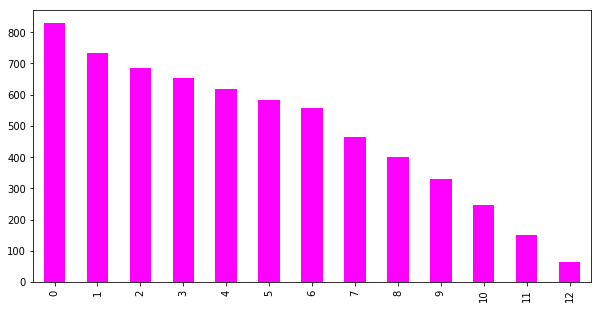

In [23]:
#Days Since first Trip drivers

plt.rcParams["figure.figsize"] =  [10,5]
weekly_driver_stats[weekly_driver_stats.columns[1:]].count().plot(kind='bar',color="fuchsia")

In [24]:
# The drop after 6 weeks is mainly attributed to different lengths of driver lifetimes for last onboared driver we have 6 weeks of rides data only - 
#So for now lets check only 6 weeks percent difference to help decide for the churn definition
print(weekly_driver_stats[weekly_driver_stats.columns[1:]].count())

weekly_driver_stats.count().pct_change()

# From bove 3-4 week inactivity can be a good signal for Churned Driver

0     829
1     732
2     687
3     653
4     618
5     584
6     556
7     465
8     401
9     331
10    247
11    150
12     64
dtype: int64


driver_id         NaN
0           -0.009558
1           -0.117008
2           -0.061475
3           -0.049491
4           -0.053599
5           -0.055016
6           -0.047945
7           -0.163669
8           -0.137634
9           -0.174564
10          -0.253776
11          -0.392713
12          -0.573333
dtype: float64

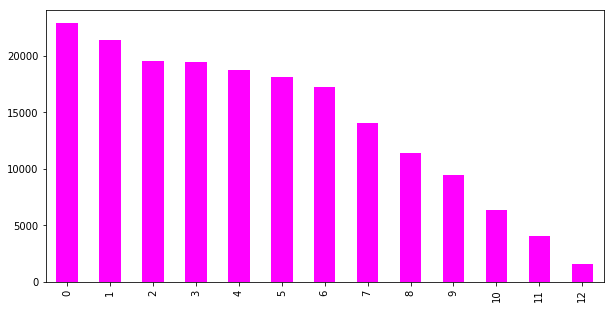

In [25]:
#Rides counts done on days since _first_trip
weekly_driver_stats[weekly_driver_stats.columns[1:]].sum().plot(kind='bar',color="fuchsia")

In [74]:

# Linear regression on each driver ride counts on different days_since_onboard to understand the rides volume up or down trend

weekly_driver_stats.fillna(0,inplace =True)

weekly_driver_stats_std = weekly_driver_stats.loc[:, weekly_driver_stats.columns != 'driver_id']
#weekly_driver_stats_std=pd.DataFrame.as_matrix(weekly_driver_stats_std) -actual count

#Standardize the counts before regression 
weekly_driver_stats_std=stats.zscore(weekly_driver_stats_std,axis=1)

intercept_list=[]
slope_list =[]
r_value_list =[]
p_value_list =[]
std_err_list =[]
x = np.arange(np.size(weekly_driver_stats_std,1))

for i in range(len(weekly_driver_stats_std)):
    y= weekly_driver_stats_std[i]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    intercept_list.append(intercept)
    slope_list.append(slope)
    r_value_list.append(r_value)
    p_value_list.append(p_value)
    std_err_list.append(std_err)

print(std_err_list)
weekly_driver_stats_reg_scores = weekly_driver_stats.copy()
weekly_driver_stats_reg_scores['intercept_list'] = std_err_list
weekly_driver_stats_reg_scores['slope_list'] = slope_list
weekly_driver_stats_reg_scores['r_value'] = r_value_list
weekly_driver_stats_reg_scores['p_value'] = p_value_list
weekly_driver_stats_reg_scores['std_err_list'] = std_err_list

weekly_driver_stats_reg_scores.head(2)
    

[0.08053204187500855]


ValueError: Length of values does not match length of index

In [72]:
# So it looks like lot of drivers have negative slope, So its more important to give chances for Drivers who are doing well in first few weeks to get more rides to stop the churn
weekly_driver_stats_reg_scores.groupby(.05* np.ceil(weekly_driver_stats_reg_scores.slope_list/.05)).driver_id.count()

slope_list
-0.25      6
-0.20    176
-0.15    277
-0.10    173
-0.05     79
-0.00     45
 0.05     36
 0.10     24
 0.15     13
 0.20      6
 0.25      2
Name: driver_id, dtype: int64

In [28]:
#I tried Linear regression as baseline model - to determine the trend

#based of regression below are the drivers that have high chance to churn
weekly_driver_stats_reg_scores.sort_values('slope_list', ascending=True).head(5)


,driver_id,0,1,2,3,4,5,6,7,8,9,10,11,12,intercept_list,slope_list,r_value,p_value,std_err_list
735,ded0963ff2f6582b382b72de6f123a08,57.0,71.0,55.0,62.0,39.0,36.0,28.0,14.0,1.0,10.0,1.0,0.0,0.0,0.025260,-0.253791,-0.949599,7.052904e-07,0.025260
653,c1909690dc34d322b9483c10cb1a533a,52.0,41.0,37.0,33.0,35.0,15.0,26.0,21.0,0.0,0.0,0.0,0.0,0.0,0.026141,-0.252807,-0.945918,1.031909e-06,0.026141
325,619fb670865cb3e2583cc22fde1337f1,111.0,96.0,89.0,92.0,94.0,59.0,62.0,64.0,3.0,0.0,0.0,0.0,0.0,0.027006,-0.251805,-0.942170,1.480984e-06,0.027006
384,72118f61d16a22814cfe01fcffd0659f,32.0,38.0,35.0,34.0,22.0,20.0,13.0,21.0,3.0,12.0,0.0,0.0,0.0,0.027395,-0.251343,-0.940438,1.736069e-06,0.027395
410,77c589b9398709f398778a0ff368e00e,97.0,83.0,55.0,65.0,41.0,38.0,8.0,29.0,6.0,0.0,0.0,0.0,0.0,0.028170,-0.250399,-0.936908,2.366542e-06,0.028170


In [29]:
#Low chances of churn drivers
weekly_driver_stats_reg_scores.sort_values('slope_list', ascending=True).tail(5)

,driver_id,0,1,2,3,4,5,6,7,8,9,10,11,12,intercept_list,slope_list,r_value,p_value,std_err_list
652,c12c2eb875879488e687111335a12805,38.0,6.0,4.0,4.0,6.0,3.0,64.0,55.0,60.0,57.0,55.0,67.0,40.0,0.059236,0.181194,0.677965,0.010874,0.059236
145,2d42e6d775b4399a56b71c2f3d6905ab,3.0,6.0,0.0,1.0,4.0,25.0,39.0,30.0,26.0,22.0,19.0,23.0,26.0,0.058659,0.183246,0.685644,0.009682,0.058659
530,9c5a3250d9f6e6537b3b076b26ce16cb,16.0,11.0,8.0,11.0,18.0,0.0,28.0,30.0,40.0,38.0,22.0,37.0,31.0,0.055767,0.192924,0.721855,0.005338,0.055767
330,630559dc85053c746beafacbd590e8f0,5.0,27.0,11.0,13.0,25.0,10.0,44.0,11.0,32.0,54.0,33.0,42.0,67.0,0.052699,0.202188,0.756518,0.002762,0.052699
425,7c27405cefee2fad79a81a819ca9dbe1,0.0,16.0,16.0,39.0,3.0,4.0,16.0,22.0,67.0,88.0,69.0,64.0,71.0,0.047604,0.215640,0.806852,0.000858,0.047604


                  0          1          2          3          4          5  \
clusters                                                                     
0         15.817982  11.206140   8.453947   7.853070   5.796053   6.103070   
1         41.076115  42.637795  41.178478  41.608924  42.118110  40.128609   

                  6          7          8          9         10        11  \
clusters                                                                    
0          6.381579   6.377193   6.296053   6.903509   5.015351  2.879386   
1         37.677165  29.244094  22.377953  16.580052  10.803150  7.333333   

                12  n_active_weeks  
clusters                            
0         1.539474        6.015351  
1         2.262467        9.380577  


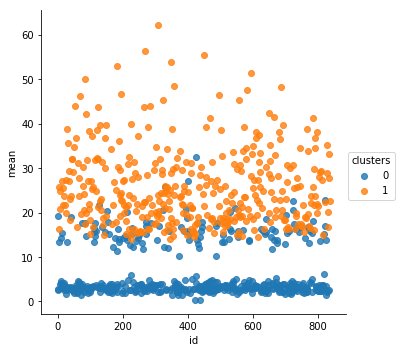

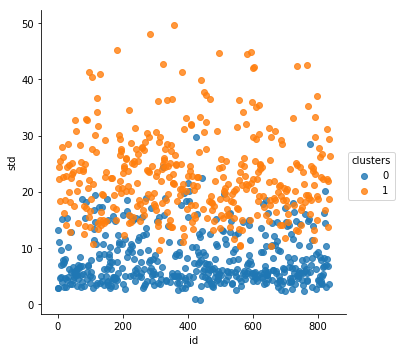

In [30]:
#Clustering drivers by weekly ride activity log

from scipy import stats
from sklearn.cluster import KMeans

wds_cluster = weekly_driver_stats.copy()


#Standardize - have to decide between standardize or not
wds_cluster_std = stats.zscore(wds_cluster.loc[:,wds_cluster.columns!= 'driver_id'],axis=1)

#Cluster the data
kmeans = KMeans(n_clusters=2, random_state=0).fit(wds_cluster.loc[:,wds_cluster.columns!= 'driver_id'])

#kmeans = KMeans(n_clusters=3, random_state=0).fit(dds_cluster_std)
labels = kmeans.labels_

wds_cluster['n_active_weeks'] = wds_cluster.loc[:,wds_cluster.columns!= 'driver_id'].apply(lambda x: (x>0)).sum(axis=1)
#Glue back to originaal data
wds_cluster['clusters'] = labels


#Lets analyze the clusters
print wds_cluster.groupby(['clusters']).mean()

wds_cluster['mean'] = wds_cluster.loc[:,wds_cluster.columns!= 'driver_id'].mean(axis=1)
wds_cluster['std'] = wds_cluster.loc[:,wds_cluster.columns!= 'driver_id'].std(axis=1)
wds_cluster['cv'] =  wds_cluster['mean']/wds_cluster['std']
wds_cluster['id'] =wds_cluster.index.values

#Scatter plot of Wattage and Duration
sns.lmplot('id', 'mean', 
           data=wds_cluster, 
           fit_reg=False, 
           hue="clusters"
        )

#Scatter plot of Wattage and Duration
sns.lmplot('id', 'std', 
           data=wds_cluster, 
           fit_reg=False, 
           hue="clusters"
        )

In [31]:
wds_cluster.head(2)

,driver_id,0,1,2,3,4,5,6,7,8,9,10,11,12,n_active_weeks,clusters,mean,std,cv,id
0,002be0ffdc997bd5c50703158b7c2491,26.0,13.0,41.0,29.0,3.0,10.0,3.0,26.0,14.0,42.0,37.0,16.0,17.0,13,0,19.333333,13.158858,1.469226,0
1,007f0389f9c7b03ef97098422f902e62,1.0,1.0,0.0,5.0,6.0,3.0,0.0,6.0,0.0,5.0,0.0,2.0,2.0,9,0,2.666667,2.772885,0.961694,1


In [32]:
#mean here especially on boolean variables gives the percentage:

all_rides.describe().T

,count,mean,std,min,25%,50%,75%,max
ride_distance,184209.0,6945.197042,8938.015943,-2.000000,2457.000000,4007.000000,7169.000000,724679.000000
ride_duration,184209.0,859.872292,572.846146,2.000000,492.000000,727.000000,1070.000000,28204.000000
ride_prime_time,184209.0,17.373880,30.833558,0.000000,0.000000,0.000000,25.000000,500.000000
nunique_days_drove,184209.0,44.814504,15.624144,2.000000,36.000000,45.000000,56.000000,81.000000
ride_distance_miles,184209.0,4.315544,5.553824,-0.001243,1.526709,2.489834,4.454609,450.294515
ride_duration_mins,184209.0,14.331205,9.547436,0.033333,8.200000,12.116667,17.833333,470.066667
week1_ride,184209.0,0.124114,0.329713,0.000000,0.000000,0.000000,0.000000,1.000000
day1_ride,184209.0,0.021188,0.144011,0.000000,0.000000,0.000000,0.000000,1.000000
is_ride_prime_time,184209.0,0.353414,0.478031,0.000000,0.000000,0.000000,1.000000,1.000000
first_to_last_ride_days,184209.0,63.886287,16.405402,1.000000,52.000000,66.000000,78.000000,89.000000


In [33]:
#Building the Rides perhour per Day seasonality


rides_day_hour=pd.pivot_table(all_rides, values='ride_id', index= ['day_of_week_n','day_of_week'] ,columns=['hour'] , aggfunc=np.size)
rides_day_hour.head(2)


,hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day_of_week_n,day_of_week,,,,,,,,,,,,,,,,,,,,,,,,
0,Mon,408,225,157,72,120,239,484,951,1167,1247,1060,959,928,904,909,978,1045,1289,1540,1437,1288,1321,1041,685
1,Tue,404,225,115,53,99,225,547,1124,1429,1512,1217,1038,1052,981,979,1110,1277,1530,1850,1823,1572,1453,1260,940


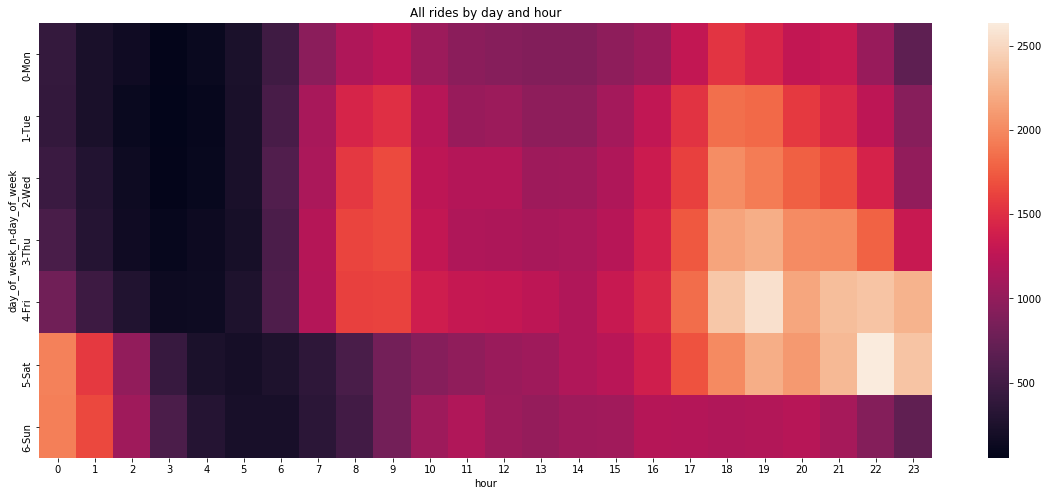

In [34]:
#All rides_heatmap - Friday night and Saturday Night hours dominate rides_per_hour-  could be riders are taking rides to restaurants/bars/events that are are open late night and public transit/driving is inconvenient.
#So far It looks like Visually  Sunday 5pm - Friday 5pm  is (More of weekday pattern) and (Friday 5pm- Sunday 5pm) are more night heavy segment Socializers
#From this data Looks like a Bustling Downtown city with Lots of night events 

plt.rcParams["figure.figsize"] = [20,8]
# These are all the calls
ax = sns.heatmap(rides_day_hour)
ax.set_title('All rides by day and hour');

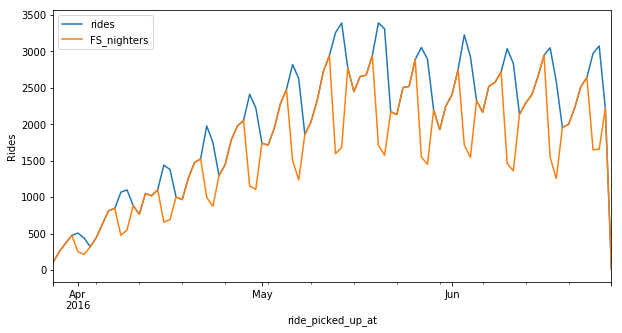

In [35]:
#Time series view into data and analyzing the  - Blue's here indicating the Friday & Saturday night time rides
plt.rcParams["figure.figsize"] =  [10,5]

all_rides_date = all_rides[['ride_picked_up_at','driver_onboard_date','is_ride_prime_time','weekday_ride','FS_nighters']].copy()
all_rides_date['rides'] = 1
all_rides_date = all_rides_date.set_index('ride_picked_up_at')
all_rides_date['rides'].resample("1D").sum().plot(legend =True)
all_rides_date[all_rides_date['FS_nighters']==0].FS_nighters.resample("1D").count().plot(legend =True)
plt.ylabel('Rides')
plt.show()

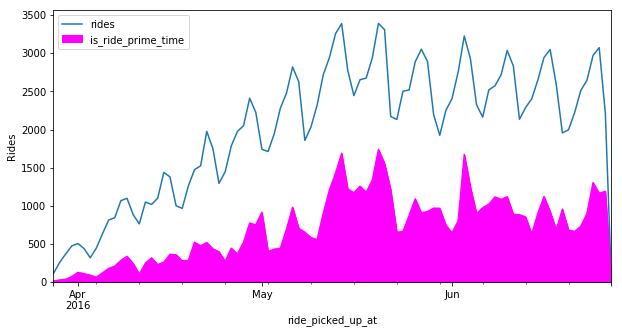

In [36]:

all_rides_date['rides'].resample("1D").count().plot(legend=True)
all_rides_date['is_ride_prime_time'].resample("1D").sum().plot(legend=True,kind="area",color="fuchsia")

plt.ylabel('Rides')
plt.show()

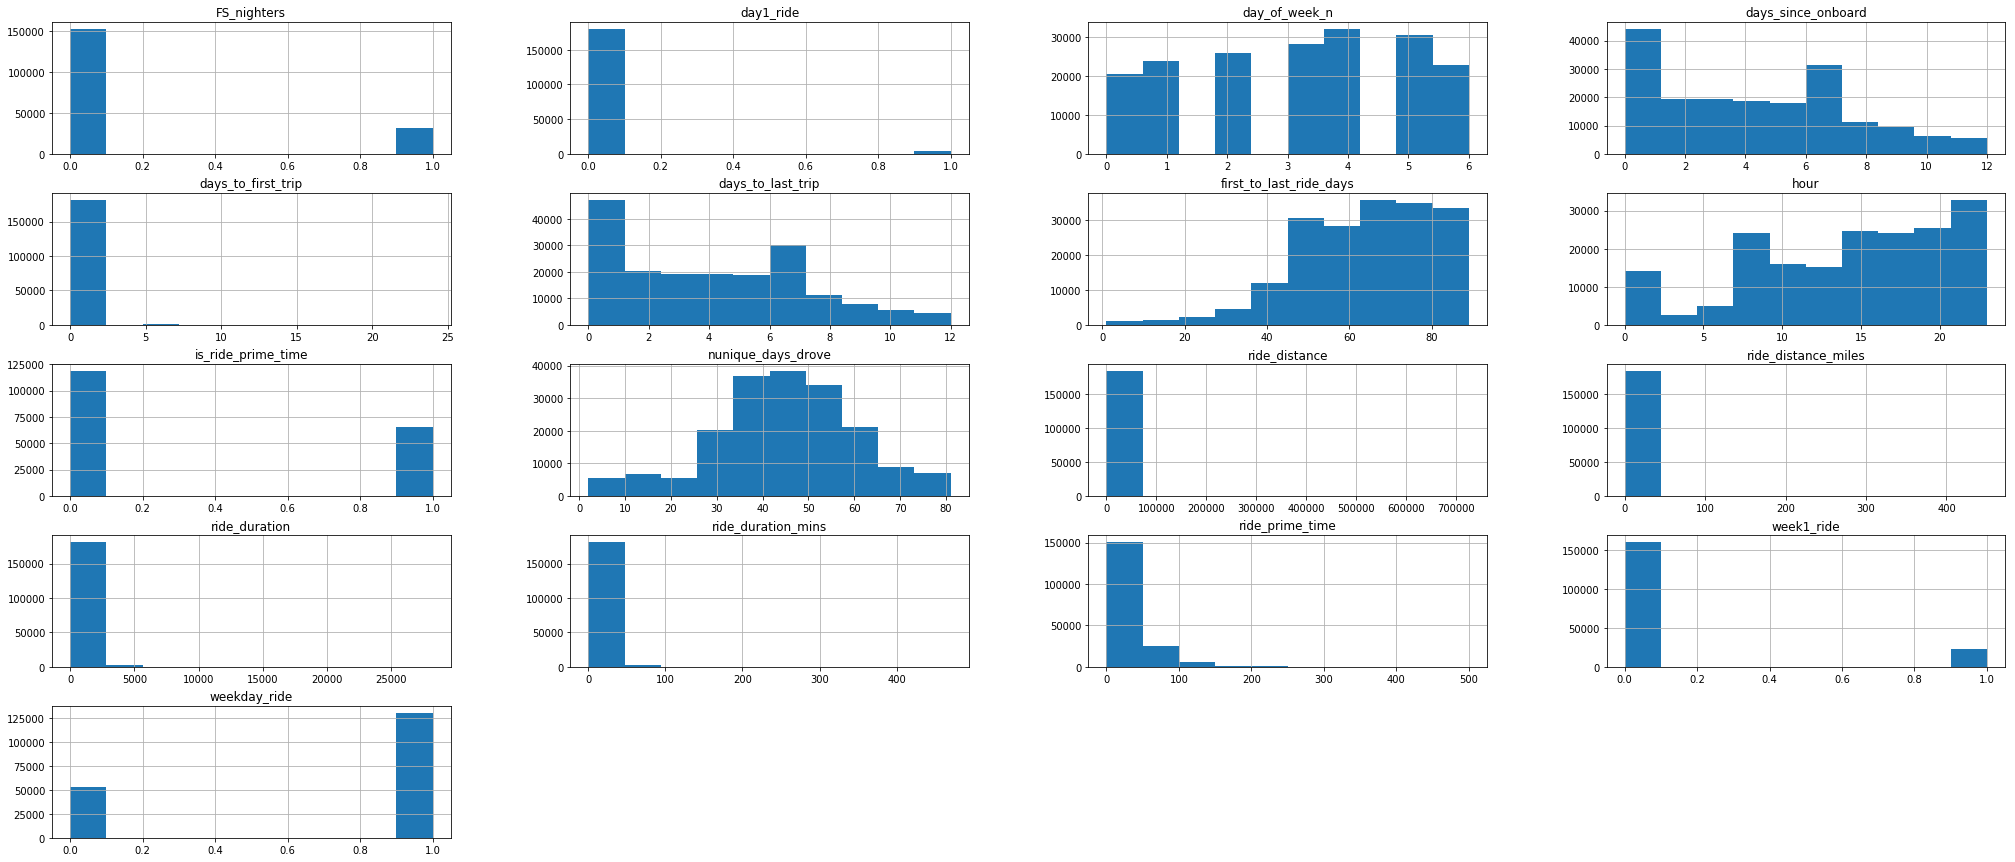

In [37]:
#Univariate analysis
plt.rcParams["figure.figsize"] = [35,15]
all_rides.hist(stacked=True)
plt.show()

In [38]:
#Finally putting it all together

#Getting all the driver Stats aggregation

driver_agg_dict = {'ride_picked_up_at': { 'rides_total':'count','ride_picked_up_at_first': 'min', 'ride_picked_up_at_last' :'max'},
            'driver_onboard_date' : {'driver_onboard_date_min':'min'},
            'ride_duration_mins' : {'ride_duration_mins_total':'sum','ride_duration_median':'median'},
            'ride_distance_miles' : {'ride_distance_miles_total':'sum','ride_distance_miles_median':'median'},
            'is_ride_prime_time': {'prime_time_pct':'mean'},
            'ride_prime_time':{'avg_prime_time_rate':'mean'},
            'ride_prime_time':{'avg_prime_time_rate':'mean'},
            'weekday_ride': {'weekday_pct':'mean'},
            'FS_nighters': {'FS_nighters_pct':'mean'},       
            'week1_ride':{'had_week1_ride': 'max','week1_rides':'sum'},
            'day1_ride':{'had_day1_ride': 'max','day1_rides':'sum'},
            'nunique_days_drove': {'nunique_days_drove':'max'}                   
           }

driver_stats = all_rides.groupby(['driver_id']).agg(driver_agg_dict)
driver_stats.columns = driver_stats.columns.droplevel()
driver_stats.reset_index(inplace=True)

driver_stats['first_to_last_ride_days'] =  ((driver_stats['ride_picked_up_at_last'].dt.date - driver_stats['ride_picked_up_at_first'].dt.date)/ np.timedelta64(1,'D')).astype(int)



/Users/abhishekarya/anaconda2/lib/python2.7/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [39]:
#Fianlly Merging all the hardwork above on Driver data

#Mergin othere drivers stats data
driver_stats_all =pd.merge(driver_stats,weekly_driver_stats_reg_scores[['driver_id','intercept_list','slope_list','r_value','p_value','std_err_list']],how='left',on='driver_id').merge(wds_cluster,how='left',on='driver_id')
driver_stats_all['n_active_days_pct'] = driver_stats_all['nunique_days_drove']/(1.0 +driver_stats_all['first_to_last_ride_days'])

#Since we have Six weeks of data for all the rides -hence using moving average of rides on Last 6 weeks to determine if the Drivers are low volume or power drivers

driver_stats_all['last6_weeks_avg_rides_ma'] = (driver_stats_all['12'] + driver_stats_all['11'] + driver_stats_all['10'] + driver_stats_all['9'] + driver_stats_all['8'] + driver_stats_all['7'])/6
driver_stats_all['rides_per_week_avg'] = driver_stats_all['mean']

churn_avg_rides_per_week_low = 5

driver_stats_all['power_driver'] = np.where(driver_stats_all['last6_weeks_avg_rides_ma'] > churn_avg_rides_per_week_low,1,0)



driver_stats_all['miles_per_hour'] = (driver_stats_all['ride_distance_miles_total']*60.0) / driver_stats_all['ride_duration_mins_total']

driver_stats_all['miles_per_ride'] = (driver_stats_all['ride_distance_miles_total'] / driver_stats_all['rides_total'])

driver_stats_all['mins_per_ride'] = (driver_stats_all['ride_duration_mins_total']/ driver_stats_all['rides_total'])



# Power Driver its better keep a small window of 1 weeks and for Small ride volume driver window is set to be 4 weeks

#Define Churn

churn_cut_off_low_ride = driver_stats_all['ride_picked_up_at_last'].max() -  pd.Timedelta('28 day')
churn_cut_off_power = driver_stats_all['ride_picked_up_at_last'].max() -  pd.Timedelta('7 day')


print("Cut off datetime stamp for churn for power driver: %s and churn for low volume driver: %s" % (churn_cut_off_power,churn_cut_off_low_ride))

driver_stats_all['churned_driver']= (np.where( (( (driver_stats_all['power_driver']==1) & (driver_stats_all['ride_picked_up_at_last'] < churn_cut_off_power)) |
                                           ( ((driver_stats_all['power_driver']==0)) & (driver_stats_all['ride_picked_up_at_last'] < churn_cut_off_low_ride))),1,0))


driver_stats_all.head(2)



Cut off datetime stamp for churn for power driver: 2016-06-20 00:02:06 and churn for low volume driver: 2016-05-30 00:02:06


,driver_id,driver_onboard_date_min,nunique_days_drove,avg_prime_time_rate,prime_time_pct,weekday_pct,ride_duration_median,ride_duration_mins_total,FS_nighters_pct,day1_rides,had_day1_ride,week1_rides,had_week1_ride,ride_distance_miles_total,ride_distance_miles_median,rides_total,ride_picked_up_at_first,ride_picked_up_at_last,first_to_last_ride_days,intercept_list,slope_list,r_value,p_value,std_err_list,0,1,2,3,4,5,6,7,8,9,10,11,12,n_active_weeks,clusters,mean,std,cv,id,n_active_days_pct,last6_weeks_avg_rides_ma,rides_per_week_avg,power_driver,miles_per_hour,miles_per_ride,mins_per_ride,churned_driver
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,56,19.404332,0.397112,0.772563,11.900000,3687.300000,0.140794,6,1,26,1,1081.363873,2.361210,277,2016-03-29 18:50:01,2016-06-23 10:08:13,86,0.080532,0.009437,0.035311,0.908824,0.080532,26.0,13.0,41.0,29.0,3.0,10.0,3.0,26.0,14.0,42.0,37.0,16.0,17.0,13,0,19.333333,13.158858,1.469226,0,0.643678,25.333333,19.333333,1,17.596028,3.903841,13.311552,0
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,12,20.161290,0.387097,0.709677,10.183333,341.616667,0.193548,1,1,1,1,73.030355,2.140002,31,2016-03-29 22:33:44,2016-06-22 13:20:22,85,0.080569,0.004838,0.018101,0.953197,0.080569,1.0,1.0,0.0,5.0,6.0,3.0,0.0,6.0,0.0,5.0,0.0,2.0,2.0,9,0,2.666667,2.772885,0.961694,1,0.139535,2.500000,2.666667,0,12.826720,2.355818,11.019892,0


In [40]:
#driver_stats_all.dtypes

In [41]:
print("Overall Churn Rate: %.3f%%" % ((100* driver_stats_all.churned_driver.mean())))

Overall Churn Rate: 22.103%


In [42]:
#For lot for Variable analysis Down mean is the Churn Rate

In [43]:
#Power Driver has much lower Churn rate than non Power Driver. Different Startegy is needed to each group For reducing Churn

driver_stats_all.groupby('power_driver').churned_driver.agg(['size','sum','mean'])

,size,sum,mean
power_driver,,,
0,461,153,0.331887
1,376,32,0.085106


,power_driver,prime_time_pct,size,sum,mean
2,0,0.2,73,35,0.479452
3,0,0.3,115,43,0.373913
4,0,0.4,132,39,0.295455
5,0,0.5,81,16,0.197531
10,1,0.3,87,7,0.080460
11,1,0.4,165,10,0.060606
12,1,0.5,89,12,0.134831


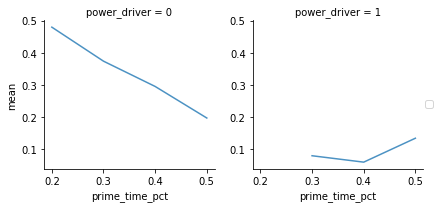

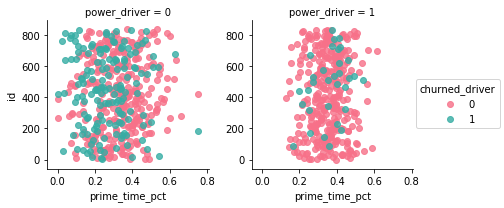

In [44]:
#prime_time_pct analysis

# Churn rate drops down for low power drivers to get the Prime time rides vs Non prime drivers where prime_time_pct > 50% 
#Probably the Power drivers that are Driving >50% of Rides as Prime time rides end up competing/ waiting for prime time rides hence wasting the ride opportunity

gp = driver_stats_all.groupby(["power_driver",.1*np.ceil(driver_stats_all['prime_time_pct']/.1)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'prime_time_pct', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'prime_time_pct','id' , alpha=.8)
g.add_legend();

gp

,power_driver,miles_per_hour,size,sum,mean
0,0,15.0,87,38,0.436782
1,0,20.0,206,63,0.305825
2,0,25.0,109,41,0.376147
3,0,30.0,47,10,0.212766
6,1,15.0,62,10,0.161290
7,1,20.0,237,17,0.071730
8,1,25.0,67,4,0.059701


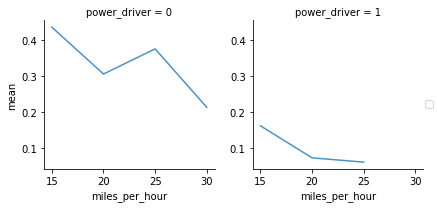

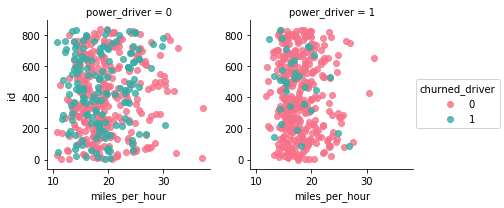

In [45]:
# Miles_per_hour Analysis:

# Churn rate Drops with Higher Miles_per_hour as that will mean higher Profit/Earnings per hour for Both Power Driver and non Power Driver

gp = driver_stats_all.groupby(["power_driver",5*np.ceil(driver_stats_all['miles_per_hour']/5)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'miles_per_hour', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'miles_per_hour','id' , alpha=.8)
g.add_legend();

gp

,power_driver,day1_rides,size,sum,mean
1,0,5.0,311,98,0.315113
2,0,10.0,107,39,0.364486
7,1,5.0,222,17,0.076577
8,1,10.0,94,10,0.106383


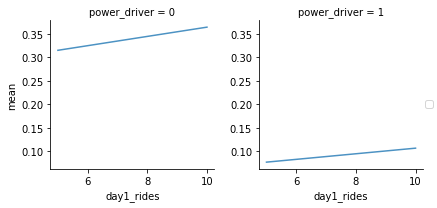

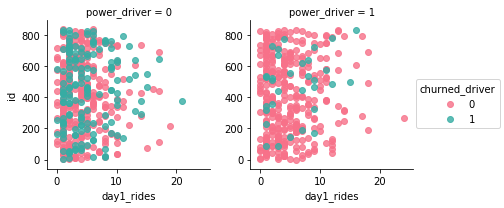

In [46]:
#Day1_rides:
#Most of the Drivers get first ride on Day1 of onboard 804/837 = 96.4%   binned by 5 rides
# I see higher churn rate with increase in Day1_rides for both groups of drivers 
#-Probably Drivers who take much more rides get frustrated on the day1- as they are still learning the ropes - so end up not doing well - So better training will probably help Driver retention


gp = driver_stats_all.groupby(["power_driver",5*np.ceil(driver_stats_all['day1_rides']/5)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'day1_rides', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'day1_rides','id' , alpha=.8)
g.add_legend();

gp

,power_driver,week1_rides,size,sum,mean
1,0,30.0,337,120,0.356083
2,0,60.0,93,30,0.322581
6,1,30.0,189,10,0.052910
7,1,60.0,132,18,0.136364
8,1,90.0,45,3,0.066667


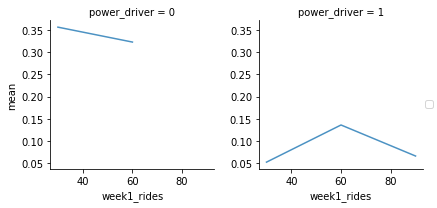

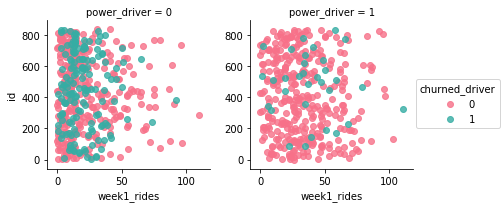

In [47]:


#Week1_rides:

#bins here are 0:0, 30:1-30, 60:31-60, 90:61-90 

# As we see as driver gets more rides in week1 motivates or is a signal for driver who is intrinsically committed to drive more - hence lower churn rate is  for drivers who drove 90+ rides in first week.

# Adding week1 Rides has much more and different impact for Power_Drivers [higher churn for 30-60 bin vs 0-30, 60-90] than Low Volume Drivers 

#So opportunity sizing Depends which bin we are adding more Drivers to.

# week1 Rides has little impact for non Power_Drivers
#and for power drivers somehow the 30-60 bin is not ideal (see an increase there) but it drops again for 90-120 week1 rides set

driver_stats_all.groupby(["power_driver",30*np.ceil(driver_stats_all['week1_rides']/30)]).churned_driver.agg(['size','sum','mean'])

gp = driver_stats_all.groupby(["power_driver",30*np.ceil(driver_stats_all['week1_rides']/30)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'week1_rides', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'week1_rides','id' , alpha=.8)
g.add_legend();

gp

,power_driver,n_active_days_pct,size,sum,mean
0,0,0.5,280,89,0.317857
1,0,1.0,181,64,0.353591
2,1,0.5,63,6,0.095238
3,1,1.0,313,26,0.083067


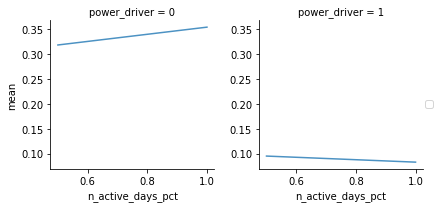

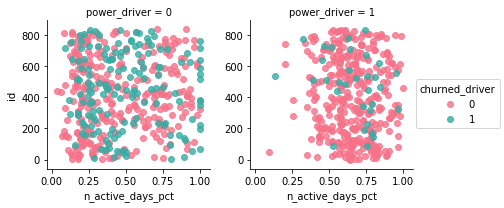

In [48]:
#n_active_days_pct
# More active days for low power driver will improve Churn rate 

gp = driver_stats_all.groupby(["power_driver",.5*np.ceil(driver_stats_all['n_active_days_pct']/.5)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'n_active_days_pct', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'n_active_days_pct','id' , alpha=.8)
g.add_legend();

gp

,power_driver,first_to_last_ride_days,size,sum,mean
0,0,20.0,71,71,1.000000
1,0,40.0,129,66,0.511628
2,0,60.0,193,16,0.082902
3,0,80.0,59,0,0.000000
5,1,60.0,64,8,0.125000
6,1,80.0,220,21,0.095455
7,1,100.0,92,3,0.032609


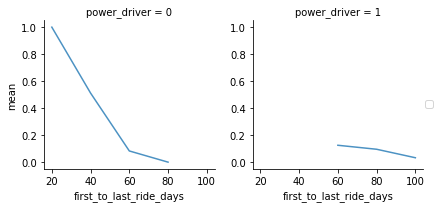

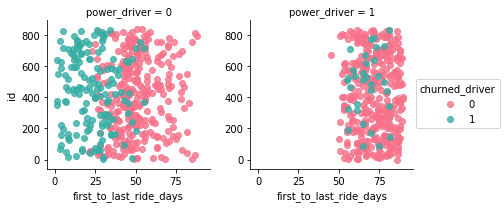

In [49]:
# Interesting segment of non power driver driver with (0-20) days with 100% Churn rate - Driver that stick with System longer usually stick as drivers and dont churn - It could be becuase of definition of Churn

gp = driver_stats_all.groupby(["power_driver",20*np.ceil(driver_stats_all['first_to_last_ride_days']/20)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'first_to_last_ride_days', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'first_to_last_ride_days','id' , alpha=.8)
g.add_legend();

gp

,power_driver,mins_per_ride,size,sum,mean
1,0,12.0,44,22,0.500000
2,0,14.0,155,62,0.400000
3,0,16.0,172,42,0.244186
4,0,18.0,64,19,0.296875
5,0,20.0,15,4,0.266667
9,1,14.0,162,11,0.067901
10,1,16.0,164,17,0.103659
11,1,18.0,35,3,0.085714


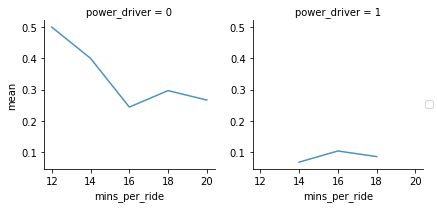

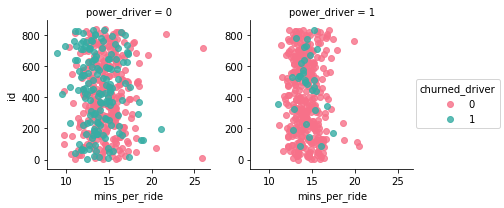

In [50]:
#mins_per_ride:
# Churn Rate Does drop especially for non Power users to get the longer duration rides and probably longer duration should mean more money especially in this region 

gp = driver_stats_all.groupby(["power_driver",2*np.ceil(driver_stats_all['mins_per_ride']/2)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>10] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'mins_per_ride', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'mins_per_ride','id' , alpha=.8)
g.add_legend();

gp

,power_driver,miles_per_ride,size,sum,mean
0,0,3.0,31,18,0.580645
1,0,4.0,147,49,0.333333
2,0,5.0,126,45,0.357143
3,0,6.0,89,25,0.280899
4,0,7.0,37,12,0.324324
5,0,8.0,16,4,0.250000
11,1,4.0,172,17,0.098837
12,1,5.0,134,8,0.059701
13,1,6.0,39,3,0.076923
14,1,7.0,13,0,0.000000


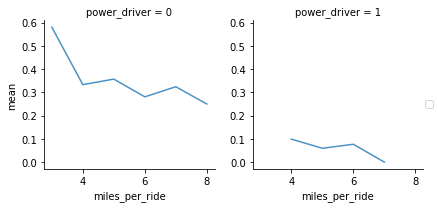

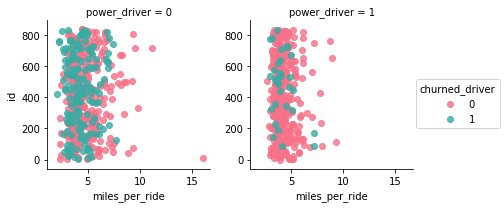

In [51]:

# Churn Rate Does drop especially for non Power users to get the longer distance rides (miles_per_ride)

gp = driver_stats_all.groupby(["power_driver",1*np.ceil(driver_stats_all['miles_per_ride']/1)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>10] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'miles_per_ride', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'miles_per_ride','id' , alpha=.8)
g.add_legend();

gp

,power_driver,weekday_pct,size,sum,mean
6,0,0.6,59,20,0.338983
7,0,0.7,72,19,0.263889
8,0,0.8,100,29,0.290000
9,0,0.9,67,25,0.373134
10,0,1.0,96,37,0.385417
17,1,0.7,106,6,0.056604
18,1,0.8,116,14,0.120690
19,1,0.9,65,7,0.107692


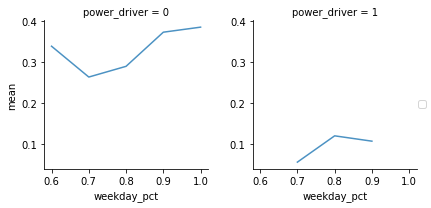

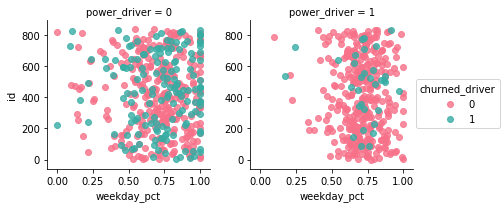

In [52]:
#Higher Weekday_pct rides are Adding to higher Churn Rate

gp = driver_stats_all.groupby(["power_driver",.1*np.ceil(driver_stats_all['weekday_pct']/.1)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'weekday_pct', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'weekday_pct','id' , alpha=.8)
g.add_legend();


gp

,power_driver,FS_nighters_pct,size,sum,mean
0,0,0.0,72,35,0.486111
1,0,0.1,98,28,0.285714
2,0,0.2,131,43,0.328244
3,0,0.3,82,22,0.268293
4,0,0.4,48,14,0.291667
9,1,0.1,86,5,0.058140
10,1,0.2,145,11,0.075862
11,1,0.3,97,11,0.113402


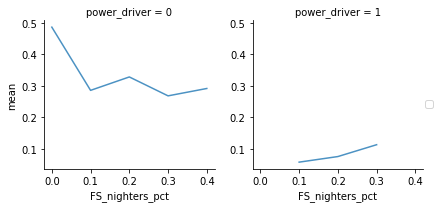

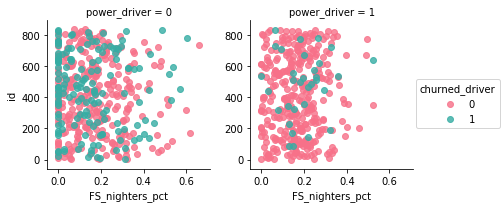

In [53]:
#For non Power Driver Churn rate is Higher for drivers who dont do Friday/Saturday Nights FS_nighters_pct=0,and it drop down quite a bit if Drivers are doing the Friday/Saturday Night Drives.

#For power user Doing more than 30% of Rides as Friday/Saturday night are showing bit higher churn 

gp = driver_stats_all.groupby(["power_driver",.1*np.ceil(driver_stats_all['FS_nighters_pct']/.1)]).churned_driver.agg(['size','sum','mean']).reset_index()

gp =gp[gp['size']>40] # (kicking out <40 Drivers bin as not worth exploring) 

g = sns.FacetGrid(gp, col="power_driver", palette="husl")
g.map(plt.plot, 'FS_nighters_pct', 'mean', alpha=.8)
g.add_legend();

g = sns.FacetGrid(driver_stats_all, col="power_driver",hue="churned_driver", palette="husl")
g.map(plt.scatter, 'FS_nighters_pct','id' , alpha=.8)
g.add_legend();

gp

In [ ]:
#Should Later convert all above groupby and charting intoa function

In [68]:
#Model Building -  Need to work on improving the model and need a test dataset
#Logistic regression  sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X = driver_stats_all[['power_driver','miles_per_hour','prime_time_pct','day1_rides']]
Y = driver_stats_all['churned_driver']

#split dataset into train set and test set#split d 

from sklearn.cross_validation import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y,test_size=0.20,random_state=10)
print("Simmilar rates ensure there is no bias introduced by splitting process")
print('Train data first_trip_done rate:', Y_train.mean())
print('Valid data first_trip_done rate::', Y_valid.mean())

#user 1e8 for Cs to match stasmodel output


lrcv = LogisticRegressionCV(Cs = [1e8,1e8,1e8,1e8,1e8,1e8],
                            dual=False,
                            class_weight="balanced",
                            scoring='accuracy',
                            max_iter=1000,
                            n_jobs=-1,
                            verbose=1)



lrcv.fit(X_train, Y_train)

#Validation data Classification report
print("Validation data accuracy: %.3f" %(lrcv.score(X_valid,Y_valid)))
print classification_report(y_true=Y_valid,y_pred=(lrcv.predict(X_valid)))


Simmilar rates ensure there is no bias introduced by splitting process
('Train data first_trip_done rate:', 0.22122571001494767)
('Valid data first_trip_done rate::', 0.22023809523809523)
Validation data accuracy: 0.667
             precision    recall  f1-score   support

          0       0.93      0.62      0.74       131
          1       0.38      0.84      0.53        37

avg / total       0.81      0.67      0.70       168



[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [55]:
print("coeffecient: %s" % (lrcv.coef_))
print("odds ratio: %s" % (np.exp(lrcv.coef_)))

coeffecient: [[-1.56420997 -0.08612718 -3.61559033  0.0480928 ]]
odds ratio: [[ 0.20925326  0.91747754  0.02690104  1.04926802]]


In [ ]:
#lrcv.predict(X).mean()

In [66]:
#Logistic regression  statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf

X_train1 = pd.concat([X_train,Y_train],axis=1)
X_train1
logit_trip_model_str = 'churned_driver ~ miles_per_hour  + prime_time_pct + power_driver + day1_rides + weekday_pct' 
logit_trip_model = smf.logit(formula = str(logit_trip_model_str), data = X_train1).fit()
logit_trip_model.summary2()



Optimization terminated successfully.
         Current function value: 0.464025
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            No. Iterations:   6.0000  
Dependent Variable: churned_driver   Pseudo R-squared: 0.122   
Date:               2018-08-05 01:15 AIC:              632.8654
No. Observations:   669              BIC:              659.9001
Df Model:           5                Log-Likelihood:   -310.43 
Df Residuals:       663              LL-Null:          -353.54 
Converged:          1.0000           Scale:            1.0000  
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept        2.4284   0.8943  2.7154 0.0066  0.6756  4.1812
miles_per_hour  -0.0956   0.0275 -3.4773 0.0005 -0.1495 -0.0417
prime_time_pct  -4.2788   0.9645 -4.4361 0.0000 -6.1692 -2.3883
power_driver    -1.5684   0.2345 -6.6869 0.0000 -2.0281 -1.1087
day1_rides       0.0484   0.0255  1.8995 0.0575 -0.0015  0.0983
weekday_pct     -0.3480   0.5430 -0.6409 0.5216 -1.4123  0.7162
===============================================================

"""

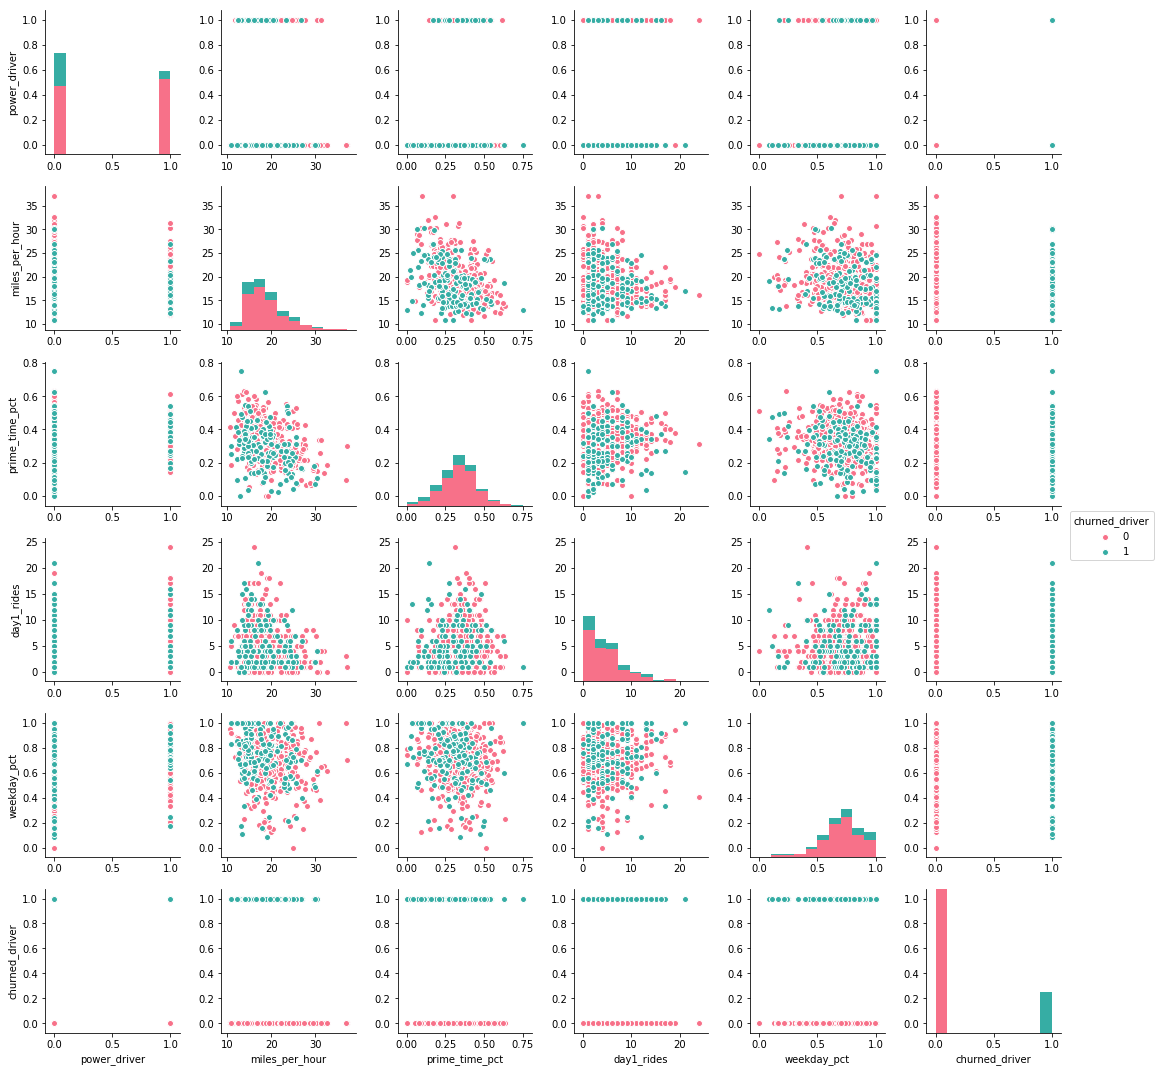

In [67]:

sns.pairplot(X_train1, hue="churned_driver", palette="husl")

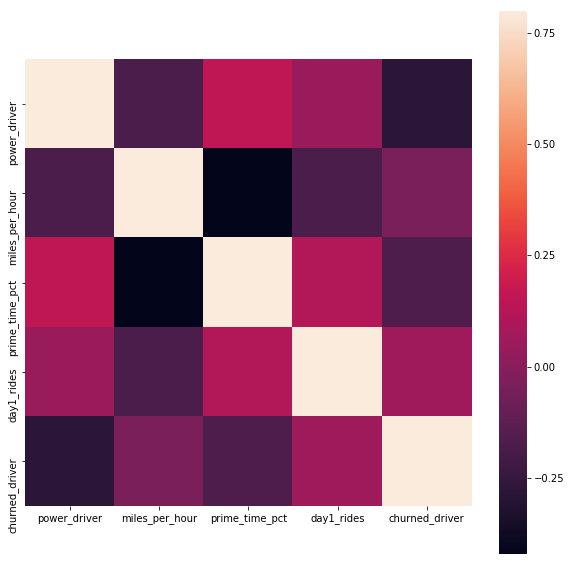

In [59]:
rcParams['figure.figsize'] = 10,10
f, ax = plt.subplots()
sns.heatmap(X_train1.corr(), vmax=.8, square=True)

In [60]:
#Experiment Elimanting Prime Time Analylsis - Sample Size Calculation

from statsmodels.stats.power import tt_ind_solve_power


#Detect stats sig difference of 5% change in avg_rides_per_driver
#lets say We want to 5% Effect size in avg_rides_per_driver 

mean_diff = driver_stats_all['rides_total'].sum()/driver_stats_all.driver_id.count()*.05
sd = driver_stats_all['rides_total'].std() #assume for sample size calculator same variance
std_effect_size = mean_diff / sd

#Experiment Elimanting Prime Time Analylsis
print('Total rides in 12 weeks: %d' % all_rides['is_ride_prime_time'].count())
print('Prime time total rides in 12 weeks: %d' % all_rides['is_ride_prime_time'].sum())
print('Avg Rides_per_Driver %d' % (driver_stats_all['rides_total'].sum()/driver_stats_all.driver_id.count()))
print('Standard Deviation Rides_per_Driver %d' % (sd))

print('\n')
n_rides_per_driver = tt_ind_solve_power(effect_size=std_effect_size, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')
print('Sample Size for each group to detect 5% delta on avg_rider_per_driver: {:.0f}'.format(n_rides_per_driver))

print('\n')


#Detect 10% delta in Driver_Churn_rate as minimum Effect size using TTest for proportions
import statsmodels.stats.api as sms

baseline_churn_pct = driver_stats_all.churned_driver.mean()

es = sms.proportion_effectsize(baseline_churn_pct,baseline_churn_pct*.90 )
print ('Detect Churn Rate Delta between baseline and effect size lowering churn rate by 10% ', round(baseline_churn_pct,3), round(baseline_churn_pct*.90,3))
n_churn = sms.NormalIndPower().solve_power(es, power=0.9, alpha=0.05, ratio=1)

print('Sample Size for each group to get 10% Delta on churn Rate : {:.0f} '.format(n_churn))

print('\n')

print('Assuming We are able to record for treatment population Rides which would from Prime time algo be Prime time ride then we can limit our data to only compare Prime Time rides on Control and treatment \n')

print('Weeks it will take to get the Sample size setup for Prime Time Ride comparison for Avg_rides_per_driver: ',np.ceil(n_rides_per_driver*12/all_rides['is_ride_prime_time'].sum()))

print('Weeks it will take to get the Sample size setup for Prime Time Ride comparison for Churn rate:',np.ceil(n_churn*12/all_rides['is_ride_prime_time'].sum()))

#2 Weeks Seem like a good timeframe to collect data and avoid any daily/weekly patterns.

Total rides in 12 weeks: 184209
Prime time total rides in 12 weeks: 65102
Avg Rides_per_Driver 220
Standard Deviation Rides_per_Driver 178


Sample Size for each group to detect 5% delta on avg_rider_per_driver: 4120


('Detect Churn Rate Delta between baseline and effect size lowering churn rate by 10% ', 0.221, 0.199)
Sample Size for each group to get 10% Delta on churn Rate : 7131 


Assuming We are able to record for treatment population Rides which would from Prime time algo be Prime time ride then we can limit our data to only compare Prime Time rides on Control and treatment 

('Weeks it will take to get the Sample size setup for Prime Time Ride comparison for Avg_rides_per_driver: ', 1.0)
('Weeks it will take to get the Sample size setup for Prime Time Ride comparison for Churn rate:', 2.0)


In [61]:
#Appendix
#sns.pairplot(driver_stats_all, hue="churned_driver", palette="husl"))


In [62]:
#rcParams['figure.figsize'] = 40,30
#f, ax = plt.subplots()
#sns.heatmap(driver_stats_all.corr(), vmax=.8, square=True)